In [1]:
!git clone https://github.com/QSong-github/AntiFormer.git

Cloning into 'AntiFormer'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 139 (delta 27), reused 0 (delta 0), pack-reused 94 (from 1)
Receiving objects: 100% (139/139), 12.49 MiB | 8.13 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [2]:
!pip install rdkit datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pathlib import Path
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer
from datasets import Dataset, load_from_disk
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from rdkit import Chem
from dataclasses import dataclass,asdict
import keras_nlp
tqdm.pandas()


In [4]:
dataset = load_from_disk('/content/AntiFormer/subdt')

In [5]:
!ls {dataset}

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `ls Dataset({'


In [6]:
df = dataset.to_pandas()
df.head()


,input_ids,label
0,"{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
1,"{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1,...",1
2,"{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1,...",1
3,"{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
4,"{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1,...",0


In [7]:
expanded = df['input_ids'].apply(pd.Series)

# Combine the expanded columns with the original 'label'
final_df = pd.concat([expanded, df['label']], axis=1)

final_df

,attention_mask,input_ids,token_type_ids,label
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 9, 8, 18, 5, 8, 9, 10, 7, 7, 7, 5, 8, 18, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 18, 9, 10, 7, 16, 7, 5, 8, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 18, 18, 24, 7, 6, 7, 5, 5, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 8, 9, 10, 7, 7, 7, 8, 8, 18,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 9, 8, 12, 5, 18, 18, 10, 7, 14, 9, 5, 8, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
...,...,...,...,...
1995,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 5, 18, 5, 18, 9, 10, 7, 16, 7, 5, 8, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1996,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 15, 9, 10, 7, 16, 7, 5, 8, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1997,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 18, 9, 10, 7, 16, 7, 5, 8, 9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1998,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 9, 8, 18, 5, 8, 9, 10, 7, 7, 7, 5, 8, 12, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [8]:
# Drop the 'token_type_ids' column
df = final_df.drop(columns=['token_type_ids'])

df.head()

,attention_mask,input_ids,label
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 9, 8, 18, 5, 8, 9, 10, 7, 7, 7, 5, 8, 18, ...",0
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 18, 9, 10, 7, 16, 7, 5, 8, 1...",1
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 18, 18, 24, 7, 6, 7, 5, 5, 1...",1
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 8, 9, 10, 7, 7, 7, 8, 8, 18,...",0
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 9, 8, 12, 5, 18, 18, 10, 7, 14, 9, 5, 8, 1...",0


In [9]:
# Create fold column
df['fold'] = None

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Assign folds
for idx, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
    df.iloc[val_idx, df.columns.get_loc('fold')] = idx

df.head()

,attention_mask,input_ids,label,fold
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 9, 8, 18, 5, 8, 9, 10, 7, 7, 7, 5, 8, 18, ...",0,3
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 18, 9, 10, 7, 16, 7, 5, 8, 1...",1,0
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 18, 18, 24, 7, 6, 7, 5, 5, 1...",1,4
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 18, 8, 18, 5, 8, 9, 10, 7, 7, 7, 8, 8, 18,...",0,2
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 9, 8, 12, 5, 18, 18, 10, 7, 14, 9, 5, 8, 1...",0,3


In [10]:
def get_data(df, batch_size, max_len, pad_value=0, drop_remainder=False, shuffle=False):
    # Step 1: Create a dataset
    inputs = {
        'token_ids': tf.keras.preprocessing.sequence.pad_sequences(df['input_ids'].tolist(), maxlen=max_len, padding='post', value=pad_value),  # Pad to max_len
        'padding_mask': tf.keras.preprocessing.sequence.pad_sequences(df['attention_mask'].tolist(), maxlen=max_len, padding='post', value=0)  # Pad to max_len
    }
    targets = df['label'].values.astype(int)

    dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
ds = get_data(df[df['fold']==0], batch_size=2, max_len=512, shuffle=False)

# Let's check some batches manually
for inputs,label in ds.take(1):   # just take 1 batch
    break
inputs

{'token_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
 array([[ 2, 18,  8, ...,  0,  0,  0],
        [ 2, 18,  8, ...,  0,  0,  0]], dtype=int32)>,
 'padding_mask': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [12]:
vocab_size = 30

In [13]:
from tensorflow import keras
import keras_hub
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
def get_model():
    # Define the model with custom configuration
    decoder = keras_hub.models.Llama3Backbone(
        num_layers=4,
        num_query_heads=12,
        hidden_dim=384,
        intermediate_dim=192,
        vocabulary_size=vocab_size,
        num_key_value_heads=12,
        rope_max_wavelength=100000,
        rope_scaling_factor=1.0,
        layer_norm_epsilon=1e-6,
        dropout=0.1,
        dtype='float32',
    )

    # Define the model architecture
    x = keras.layers.GlobalAveragePooling1D()(decoder.output)
    x = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.Model(decoder.inputs, x)
    return model

In [67]:
get_model().summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None, 384) │     23,040 │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 384) │    811,776 │ token_embedding[… │
│ (LlamaTransformerD… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 384) │    811,776 │ transformer_laye… │
│ (LlamaTransformerD… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None, 384) │    811,776 │ transformer_laye… │
│ (LlamaTransformerD… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None, 384) │    811,776 │ transformer_laye… │
│ (LlamaTransformerD… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_output_la… │ (None, None, 384) │        384 │ transformer_laye… │
│ (LlamaLayerNorm)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ sequence_output_… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 2)         │        770 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,271,298 (12.48 MB)

 Trainable params: 3,271,298 (12.48 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
import os
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow import keras
SEED = 42
# Create a directory to save models for each fold
model_save_dir = "saved_models"
os.makedirs(model_save_dir, exist_ok=True)

# List to store fold results
fold_results = []
fold_history = []
# Perform 5-fold cross-validation
for fold in range(5):
    tf.config.experimental.reset_memory_stats('GPU:0')
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.keras.backend.clear_session()
    tf.config.experimental.enable_op_determinism()

    model = get_model()  # Initialize model again for each fold

    # Compile the model
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(0.0001),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Create training and test datasets for the current fold
    ds_train = get_data(
        df=df[df['fold'] != fold],
        batch_size=4,
        max_len=512,
        drop_remainder=False,
        shuffle=True,
    )
    ds_test = get_data(
        df=df[df['fold'] == fold],
        batch_size=4,
        max_len=512,
        drop_remainder=False,
        shuffle=False,
    )

    # Track training time
    start_time = time.time()

    # Train the model
    history = model.fit(ds_train, epochs=10, validation_data=ds_test, verbose=2)
    fold_history.append(history)
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(ds_test)

    # Get predictions for the test set to calculate other metrics
    y_true = []
    y_pred = []

    for x_batch, y_batch in ds_test:
        y_true.extend(y_batch.numpy())
        y_pred.extend(model.predict(x_batch,verbose= 0).argmax(axis=-1))  # Get class predictions

    # Calculate additional metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, model.predict(ds_test)[:, 1])

    # Calculate training time for the fold
    training_time = time.time() - start_time

    # Save the model weights after each fold
    model.save_weights(os.path.join(model_save_dir, f"model_fold_{fold}.weights.h5"))

    # Store results for this fold
    fold_results.append({
        'fold': fold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
    })

    del model
    gc.collect()

# Create DataFrame from results
fold_df = pd.DataFrame(fold_results)

# Add row with averages and total training time
average_results = {
    'fold': 'Average',
    'accuracy': fold_df['accuracy'].mean(),
    'precision': fold_df['precision'].mean(),
    'recall': fold_df['recall'].mean(),
    'f1_score': fold_df['f1_score'].mean(),
    'roc_auc': fold_df['roc_auc'].mean(),
    'training_time': fold_df['training_time'].sum(),
}

fold_df = pd.concat([fold_df,pd.DataFrame([average_results])],axis = 0)

# Display the results DataFrame
fold_df


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['token_embedding/reverse_embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


400/400 - 37s - 92ms/step - loss: 0.6147 - sparse_categorical_accuracy: 0.6950 - val_loss: 0.3457 - val_sparse_categorical_accuracy: 0.8700
Epoch 2/10
400/400 - 39s - 97ms/step - loss: 0.3263 - sparse_categorical_accuracy: 0.8600 - val_loss: 0.2762 - val_sparse_categorical_accuracy: 0.8925
Epoch 3/10
400/400 - 25s - 63ms/step - loss: 0.2475 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.2522 - val_sparse_categorical_accuracy: 0.9075
Epoch 4/10
400/400 - 25s - 63ms/step - loss: 0.1879 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.2181 - val_sparse_categorical_accuracy: 0.9275
Epoch 5/10
400/400 - 26s - 65ms/step - loss: 0.1624 - sparse_categorical_accuracy: 0.9356 - val_loss: 0.2691 - val_sparse_categorical_accuracy: 0.9125
Epoch 6/10
400/400 - 40s - 101ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.1988 - val_sparse_categorical_accuracy: 0.9475
Epoch 7/10
400/400 - 25s - 64ms/step - loss: 0.0841 - sparse_categorical_accuracy: 0.9694 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['token_embedding/reverse_embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


400/400 - 37s - 92ms/step - loss: 0.6010 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.3455 - val_sparse_categorical_accuracy: 0.8600
Epoch 2/10
400/400 - 25s - 63ms/step - loss: 0.3416 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.2445 - val_sparse_categorical_accuracy: 0.9050
Epoch 3/10
400/400 - 25s - 62ms/step - loss: 0.2656 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.1842 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/10
400/400 - 25s - 62ms/step - loss: 0.2023 - sparse_categorical_accuracy: 0.9212 - val_loss: 0.1665 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/10
400/400 - 25s - 63ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.1500 - val_sparse_categorical_accuracy: 0.9475
Epoch 6/10
400/400 - 25s - 62ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.1324 - val_sparse_categorical_accuracy: 0.9450
Epoch 7/10
400/400 - 41s - 103ms/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['token_embedding/reverse_embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


400/400 - 37s - 91ms/step - loss: 0.5955 - sparse_categorical_accuracy: 0.6831 - val_loss: 0.4156 - val_sparse_categorical_accuracy: 0.7925
Epoch 2/10
400/400 - 25s - 63ms/step - loss: 0.2995 - sparse_categorical_accuracy: 0.8756 - val_loss: 0.1973 - val_sparse_categorical_accuracy: 0.9250
Epoch 3/10
400/400 - 25s - 62ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.1382 - val_sparse_categorical_accuracy: 0.9550
Epoch 4/10
400/400 - 41s - 103ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.9369 - val_loss: 0.1180 - val_sparse_categorical_accuracy: 0.9525
Epoch 5/10
400/400 - 26s - 64ms/step - loss: 0.1389 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.1036 - val_sparse_categorical_accuracy: 0.9675
Epoch 6/10
400/400 - 25s - 62ms/step - loss: 0.1216 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.0973 - val_sparse_categorical_accuracy: 0.9675
Epoch 7/10
400/400 - 25s - 63ms/step - loss: 0.1007 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['token_embedding/reverse_embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


400/400 - 37s - 93ms/step - loss: 0.6836 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.3945 - val_sparse_categorical_accuracy: 0.8300
Epoch 2/10
400/400 - 25s - 63ms/step - loss: 0.3392 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.3105 - val_sparse_categorical_accuracy: 0.8650
Epoch 3/10
400/400 - 25s - 63ms/step - loss: 0.2584 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.1954 - val_sparse_categorical_accuracy: 0.9225
Epoch 4/10
400/400 - 25s - 63ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.1579 - val_sparse_categorical_accuracy: 0.9550
Epoch 5/10
400/400 - 25s - 63ms/step - loss: 0.1516 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.1495 - val_sparse_categorical_accuracy: 0.9475
Epoch 6/10
400/400 - 25s - 63ms/step - loss: 0.1200 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.1729 - val_sparse_categorical_accuracy: 0.9400
Epoch 7/10
400/400 - 25s - 63ms/step - loss: 0.0935 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.1

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['token_embedding/reverse_embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


400/400 - 36s - 90ms/step - loss: 0.6533 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.5829 - val_sparse_categorical_accuracy: 0.6425
Epoch 2/10
400/400 - 40s - 99ms/step - loss: 0.3878 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.2589 - val_sparse_categorical_accuracy: 0.9175
Epoch 3/10
400/400 - 25s - 63ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.8700 - val_loss: 0.1906 - val_sparse_categorical_accuracy: 0.9250
Epoch 4/10
400/400 - 25s - 63ms/step - loss: 0.2113 - sparse_categorical_accuracy: 0.9181 - val_loss: 0.1664 - val_sparse_categorical_accuracy: 0.9275
Epoch 5/10
400/400 - 25s - 63ms/step - loss: 0.1816 - sparse_categorical_accuracy: 0.9250 - val_loss: 0.1323 - val_sparse_categorical_accuracy: 0.9475
Epoch 6/10
400/400 - 25s - 63ms/step - loss: 0.1414 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.1239 - val_sparse_categorical_accuracy: 0.9525
Epoch 7/10
400/400 - 25s - 63ms/step - loss: 0.1135 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.0

,fold,accuracy,precision,recall,f1_score,roc_auc,training_time
0,0,0.9550,0.969388,0.940594,0.954774,0.988574,357.602587
1,1,0.9525,0.950980,0.955665,0.953317,0.991348,297.354685
2,2,0.9675,0.984694,0.950739,0.967419,0.996074,354.254089
3,3,0.9725,0.975248,0.970443,0.972840,0.996874,327.353119
4,4,0.9725,0.970588,0.975369,0.972973,0.995086,312.178262
0,Average,0.9640,0.970180,0.958562,0.964264,0.993591,1648.742742


In [75]:
fold_df['minutes'] = fold_df['training_time'] / 60
fold_df

,fold,accuracy,precision,recall,f1_score,roc_auc,training_time,minutes
0,0,0.9550,0.969388,0.940594,0.954774,0.988574,357.602587,5.960043
1,1,0.9525,0.950980,0.955665,0.953317,0.991348,297.354685,4.955911
2,2,0.9675,0.984694,0.950739,0.967419,0.996074,354.254089,5.904235
3,3,0.9725,0.975248,0.970443,0.972840,0.996874,327.353119,5.455885
4,4,0.9725,0.970588,0.975369,0.972973,0.995086,312.178262,5.202971
0,Average,0.9640,0.970180,0.958562,0.964264,0.993591,1648.742742,27.479046


In [68]:
fold_df.to_csv("result.csv",index = False)

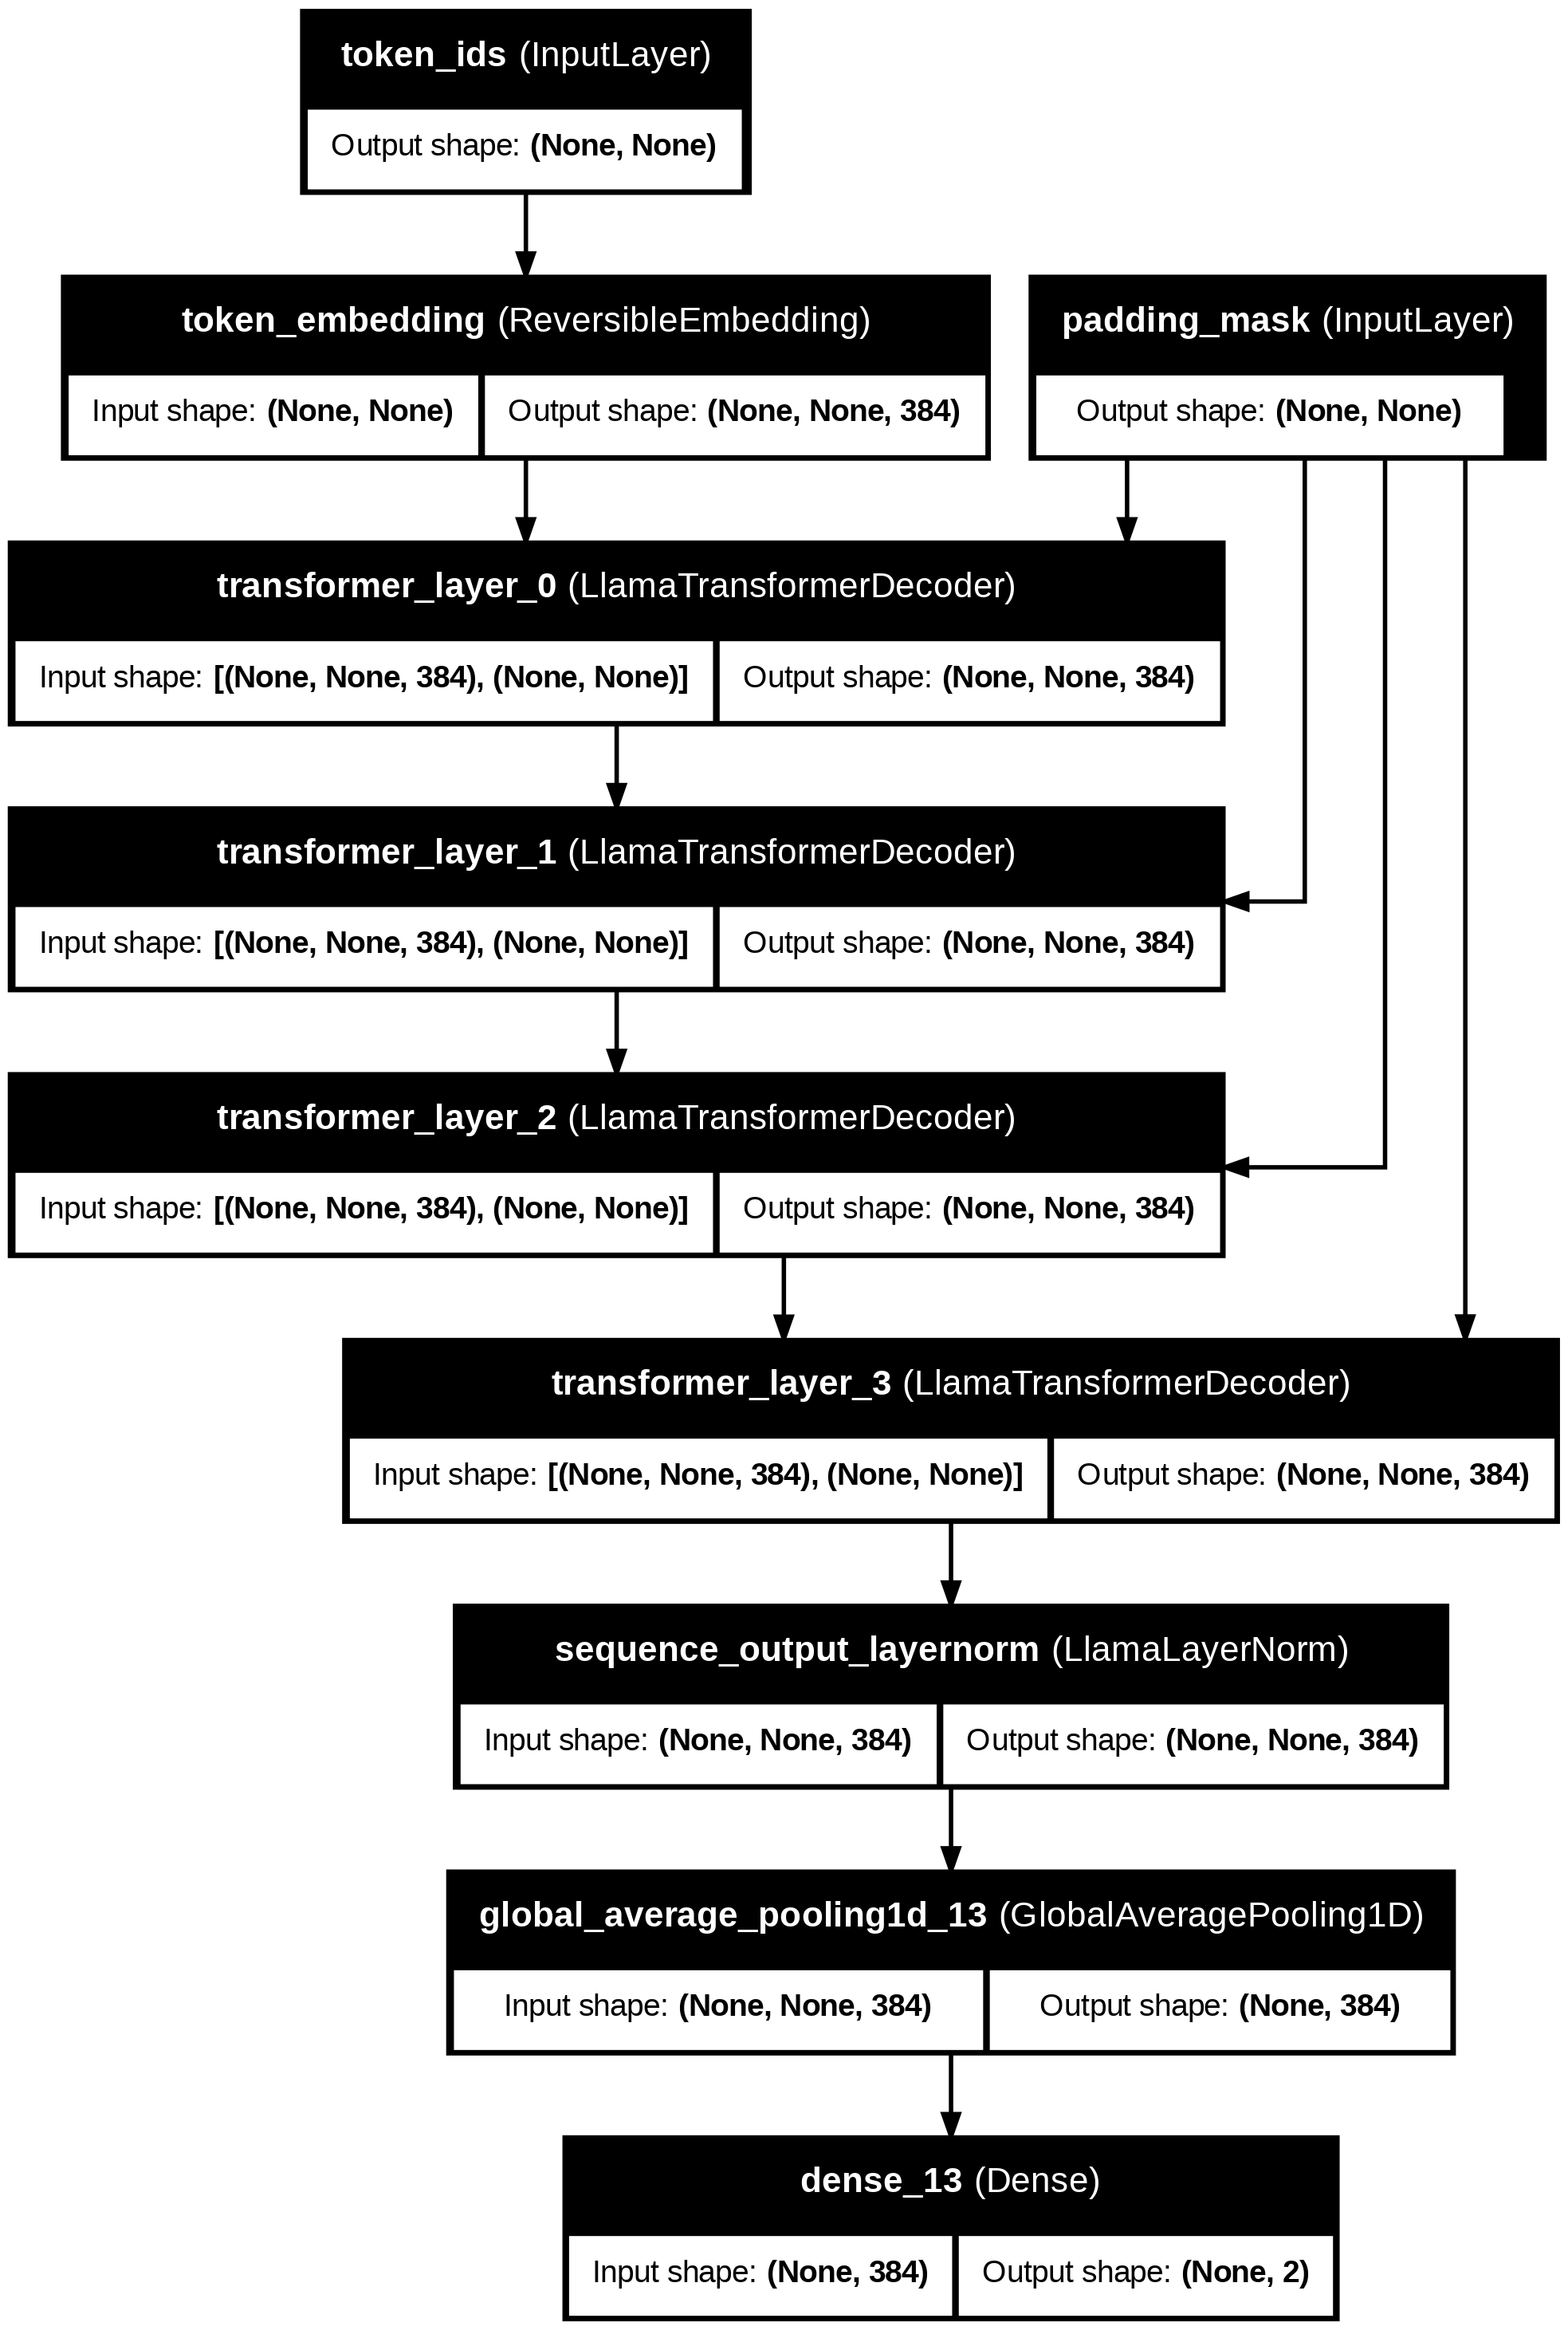

In [48]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [40]:
# Now generate graphs (Confusion Matrix, ROC-AUC, Loss, and Accuracy)
# Load saved models and predict for each fold
y_true_all = []
y_pred_all = []
losses = []
accuracies = []

for fold in range(5):
    # Load model
    model = get_model()
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(0.0001),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    model.load_weights(os.path.join(model_save_dir, f"model_fold_{fold}.weights.h5"))
    ds_test = get_data(
        df=df[df['fold'] == fold],
        batch_size=4,
        max_len=512,
        drop_remainder=False,
        shuffle=False,
    )
    # Get predictions for the test set to calculate other metrics
    y_true = []
    y_pred = []
    for x_batch, y_batch in ds_test:
        y_true.extend(y_batch.numpy())
        y_pred.extend(model.predict(x_batch,verbose = 0))  # Get class predictions

    # Collect true and predicted values for plotting
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)

    # Get loss and accuracy for each fold
    loss, accuracy = model.evaluate(ds_test,verbose = 0)
    losses.append(loss)
    accuracies.append(accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
y_true_all = np.asarray(y_true_all)
y_pred_all = np.asarray(y_pred_all)

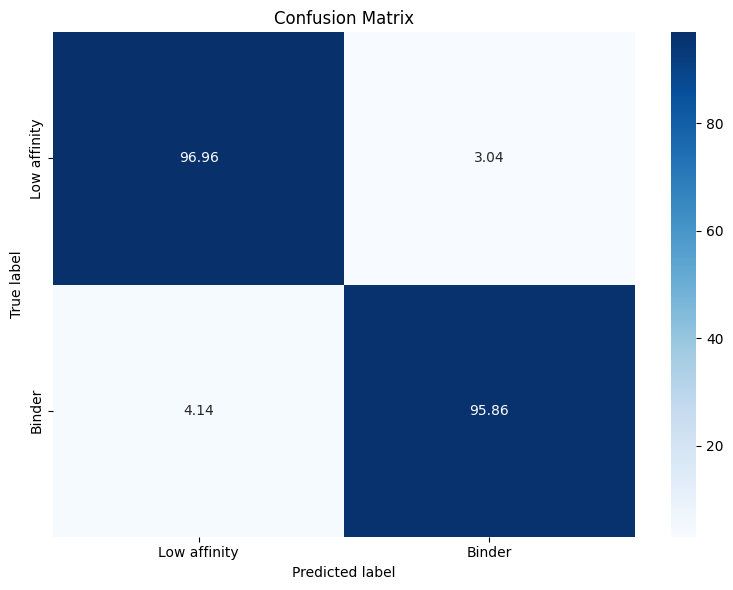

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_true_all and y_pred_all are defined
cm = confusion_matrix(y_true_all, y_pred_all.argmax(-1))

# Normalize confusion matrix to percentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low affinity', 'Binder'], yticklabels=['Low affinity', 'Binder'], cbar=True)

# Set titles and labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show the plot
plt.tight_layout()
plt.show()


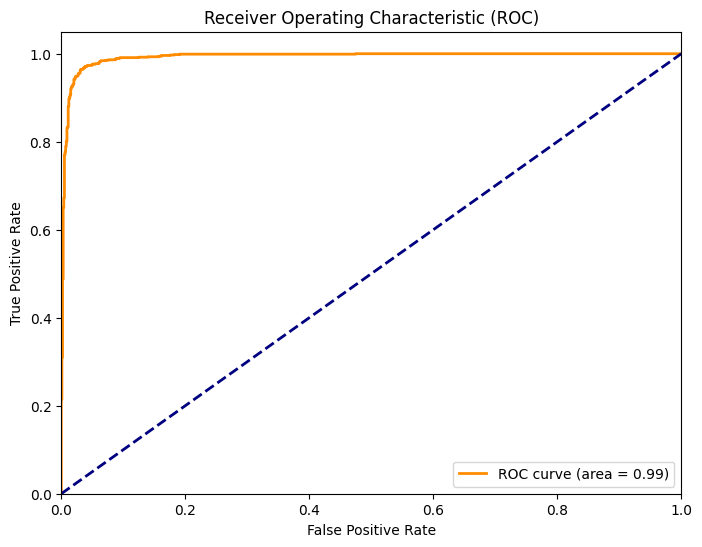

In [46]:
# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_true_all, y_pred_all[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

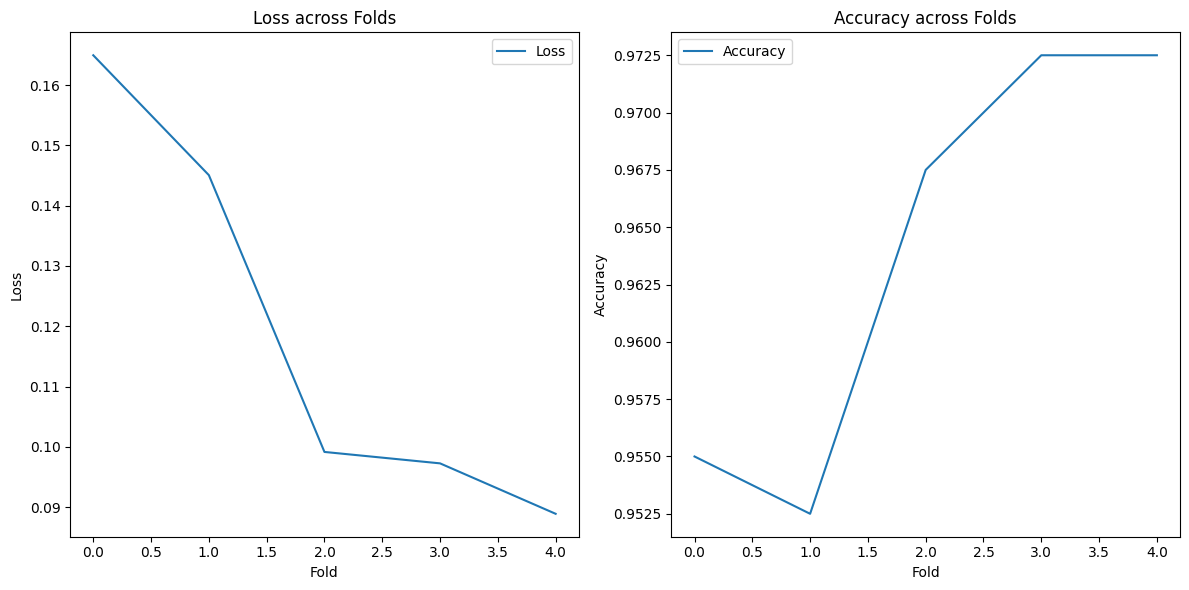

In [47]:
# Loss and Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title('Loss across Folds')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
!zip -r saved_models_v1.zip saved_models

  adding: saved_models/ (stored 0%)
  adding: saved_models/model_fold_4.weights.h5 (deflated 8%)
  adding: saved_models/model_fold_3.weights.h5 (deflated 8%)
  adding: saved_models/model.png (deflated 18%)
  adding: saved_models/model_fold_2.weights.h5 (deflated 8%)
  adding: saved_models/model_fold_1.weights.h5 (deflated 8%)
  adding: saved_models/model_fold_0.weights.h5 (deflated 8%)
